# Facial Expression Recognition
In this approach, we will setup a convolutional neural network to aim for an accuracy > 50%.

In [3]:
%matplotlib inline
from random import randint
import csv
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import tensorflow as tf
import numpy as np

In [2]:
session = tf.Session()
writer = tf.summary.FileWriter('logs/graph', session.graph)

### Network and Training Parameters

In [3]:
# images are 48x48 pixels
img_size = 48
img_size_flat = img_size * img_size
img_shape = (img_size, img_size)
num_classes = 7
class_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# probability to drop a unit (prevent overfitting)
dropout = 0.25

# training parameters
learning_rate = 0.001
num_steps = 20000
batch_size = 128

### Read CSV

In [4]:
# Feature Vectors (0-255)
imgs_train_byte = []
imgs_test_byte = []

# Labels (0-6)
labels_train_class = []
labels_test_class = []


with open('../fer2013.csv') as csvfile:
    readCSV = csv.reader(csvfile, delimiter=',')
    # skip CSV header
    next(readCSV)
    for row in readCSV:
        if row[2] == 'Training':
            # cast pixels to int
            pixels_train = [float(x) for x in row[1].split(' ')]
            imgs_train_byte.append(np.array(pixels_train))
            labels_train_class.append(int(row[0]))
        elif row[2] == 'PrivateTest':
            pixels_test = [float(x) for x in row[1].split(' ')]
            imgs_test_byte.append(np.array(pixels_test))
            labels_test_class.append(int(row[0]))

### Wrapping up the dataset

In [5]:
# cast to correct type and wrap into np arrays
imgs_train_byte = np.array(imgs_train_byte, dtype=np.float32)
imgs_test_byte = np.array(imgs_test_byte, dtype=np.float32)
labels_train_class = np.array(labels_train_class, dtype=np.float32)
labels_test_class = np.array(labels_test_class, dtype=np.float32)
# normalize the pixel intensitys
imgs_train = np.divide(imgs_train_byte, 255)
imgs_test = np.divide(imgs_test_byte, 255)

### Bootstrapping the Network

In [6]:
# Create the neural network
def conv_net(x_dict, n_classes, dropout, reuse, is_training):
    
    # Define a scope for reusing the variables
    with tf.variable_scope('ConvNet', reuse=reuse):
        # TF Estimator input is a dict, in case of multiple inputs
        x = x_dict['images']

        # The data input is a 1-D vector of 2304 features (48*48 pixels)
        # Reshape to match picture format [Height x Width x Channel]
        # Tensor input become 4-D: [Batch Size, Height, Width, Channel]
        x = tf.reshape(x, shape=[-1, img_size, img_size, 1])

        # Convolution Layer with 32 filters and a kernel size of 5
        conv1 = tf.layers.conv2d(x, 32, 5, activation=tf.nn.relu)
        # Max Pooling (down-sampling) with strides of 2 and kernel size of 2
        conv1 = tf.layers.max_pooling2d(conv1, 2, 2)

        # Convolution Layer with 64 filters and a kernel size of 3
        conv2 = tf.layers.conv2d(conv1, 64, 3, activation=tf.nn.relu)
        # Max Pooling (down-sampling) with strides of 2 and kernel size of 2
        conv2 = tf.layers.max_pooling2d(conv2, 2, 2)
        
        # Convolution Layer with 128 filters and a kernel size of 3
        conv3 = tf.layers.conv2d(conv2, 128, 3, activation=tf.nn.relu)
        # Max Pooling (down-sampling) with strides of 2 and kernel size of 2
        conv3 = tf.layers.max_pooling2d(conv3, 2, 2)
        
        # Convolution Layer with 256 filters and a kernel size of 3
        conv4 = tf.layers.conv2d(conv3, 256, 3, activation=tf.nn.relu)
        # Max Pooling (down-sampling) with strides of 2 and kernel size of 2
        conv4 = tf.layers.max_pooling2d(conv4, 2, 2)

        # Flatten the data to a 1-D vector for the fully connected layer
        fc1 = tf.contrib.layers.flatten(conv4)

        # Fully connected layer (in tf contrib folder for now)
        fc1 = tf.layers.dense(fc1, 1024)
        # Apply Dropout (if is_training is False, dropout is not applied)
        fc1 = tf.layers.dropout(fc1, rate=dropout, training=is_training)

        # Output layer, class prediction
        out = tf.layers.dense(fc1, n_classes)

    return out

### Defining the model using the Estimator API

In [7]:
# Define the model function (following TF Estimator Template)
def model_fn(features, labels, mode):
    
    # Build the neural network
    # Because Dropout have different behavior at training and prediction time, we
    # need to create 2 distinct computation graphs that still share the same weights.
    logits_train = conv_net(features, num_classes, dropout, reuse=False, is_training=True)
    logits_test = conv_net(features, num_classes, dropout, reuse=True, is_training=False)
    
    # Predictions
    pred_classes = tf.argmax(logits_test, axis=1)
    pred_probas = tf.nn.softmax(logits_test)
    
    # If prediction mode, early return
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode, predictions=pred_classes) 
        
    # Define loss and optimizer
    loss_op = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits=logits_train, labels=tf.cast(labels, dtype=tf.int32)))
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    train_op = optimizer.minimize(loss_op, global_step=tf.train.get_global_step())
    
    # Evaluate the accuracy of the model
    acc_op = tf.metrics.accuracy(labels=labels, predictions=pred_classes)
    
    # TF Estimators requires to return a EstimatorSpec, that specify
    # the different ops for training, evaluating, ...
    estim_specs = tf.estimator.EstimatorSpec(
      mode=mode,
      predictions=pred_classes,
      loss=loss_op,
      train_op=train_op,
      eval_metric_ops={'accuracy': acc_op})

    return estim_specs

In [8]:
# Build the Estimator
model = tf.estimator.Estimator(model_fn=model_fn, model_dir='../model')

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': './model', '_tf_random_seed': 1, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_save_checkpoints_steps': None, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100}


### Training the model

In [9]:
# Define the input function for training
input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'images': imgs_train}, y=labels_train_class,
    batch_size=batch_size, num_epochs=None, shuffle=True)
# Train the Model
model.train(input_fn, steps=num_steps)

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into ./model/model.ckpt.
INFO:tensorflow:loss = 1.94972, step = 1
INFO:tensorflow:global_step/sec: 2.01673
INFO:tensorflow:loss = 1.76746, step = 101 (49.586 sec)
INFO:tensorflow:global_step/sec: 2.04401
INFO:tensorflow:loss = 1.63291, step = 201 (48.923 sec)
INFO:tensorflow:global_step/sec: 2.05261
INFO:tensorflow:loss = 1.40672, step = 301 (48.718 sec)
INFO:tensorflow:global_step/sec: 2.05553
INFO:tensorflow:loss = 1.31101, step = 401 (48.649 sec)
INFO:tensorflow:global_step/sec: 2.05524
INFO:tensorflow:loss = 1.44795, step = 501 (48.656 sec)
INFO:tensorflow:global_step/sec: 2.05089
INFO:tensorflow:loss = 1.35904, step = 601 (48.760 sec)
INFO:tensorflow:global_step/sec: 2.05901
INFO:tensorflow:loss = 1.26341, step = 701 (48.567 sec)
INFO:tensorflow:global_step/sec: 2.05166
INFO:tensorflow:loss = 1.09406, step = 801 (48.741 sec)
INFO:tensorflow:global_step/sec: 2.05554
INFO:tensorflow:loss = 1.23384, 

INFO:tensorflow:loss = 0.0409718, step = 7801 (47.852 sec)
INFO:tensorflow:global_step/sec: 2.08231
INFO:tensorflow:loss = 0.135771, step = 7901 (48.024 sec)
INFO:tensorflow:global_step/sec: 2.09175
INFO:tensorflow:loss = 0.147288, step = 8001 (47.807 sec)
INFO:tensorflow:global_step/sec: 2.08284
INFO:tensorflow:loss = 0.0937629, step = 8101 (48.011 sec)
INFO:tensorflow:global_step/sec: 2.08854
INFO:tensorflow:loss = 0.0887747, step = 8201 (47.880 sec)
INFO:tensorflow:global_step/sec: 2.081
INFO:tensorflow:loss = 0.10269, step = 8301 (48.054 sec)
INFO:tensorflow:global_step/sec: 2.08906
INFO:tensorflow:loss = 0.21492, step = 8401 (47.869 sec)
INFO:tensorflow:global_step/sec: 2.08899
INFO:tensorflow:loss = 0.120486, step = 8501 (47.870 sec)
INFO:tensorflow:global_step/sec: 2.09029
INFO:tensorflow:loss = 0.0995622, step = 8601 (47.840 sec)
INFO:tensorflow:global_step/sec: 2.09249
INFO:tensorflow:loss = 0.104155, step = 8701 (47.790 sec)
INFO:tensorflow:Saving checkpoints for 8732 into ./

INFO:tensorflow:loss = 0.109856, step = 15601 (47.969 sec)
INFO:tensorflow:global_step/sec: 2.0874
INFO:tensorflow:loss = 0.067357, step = 15701 (47.906 sec)
INFO:tensorflow:global_step/sec: 2.08787
INFO:tensorflow:loss = 0.0104552, step = 15801 (47.896 sec)
INFO:tensorflow:global_step/sec: 2.08541
INFO:tensorflow:loss = 0.15509, step = 15901 (47.953 sec)
INFO:tensorflow:global_step/sec: 2.08577
INFO:tensorflow:loss = 0.0550382, step = 16001 (47.944 sec)
INFO:tensorflow:global_step/sec: 2.09097
INFO:tensorflow:loss = 0.041399, step = 16101 (47.825 sec)
INFO:tensorflow:global_step/sec: 2.0935
INFO:tensorflow:loss = 0.0508644, step = 16201 (47.767 sec)
INFO:tensorflow:Saving checkpoints for 16249 into ./model/model.ckpt.
INFO:tensorflow:global_step/sec: 2.08956
INFO:tensorflow:loss = 0.106307, step = 16301 (47.857 sec)
INFO:tensorflow:global_step/sec: 2.08646
INFO:tensorflow:loss = 0.0284478, step = 16401 (47.928 sec)
INFO:tensorflow:global_step/sec: 2.09258
INFO:tensorflow:loss = 0.0416

In [10]:
# Evaluate the Model
# Define the input function for evaluating
input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'images': imgs_test}, y=labels_test_class,
    batch_size=batch_size, shuffle=False)
# Use the Estimator 'evaluate' method
model.evaluate(input_fn)

INFO:tensorflow:Starting evaluation at 2018-01-21-02:08:40
INFO:tensorflow:Restoring parameters from ./model/model.ckpt-20000
INFO:tensorflow:Finished evaluation at 2018-01-21-02:08:44
INFO:tensorflow:Saving dict for global step 20000: accuracy = 0.539705, global_step = 20000, loss = 5.04987


{'accuracy': 0.53970468, 'global_step': 20000, 'loss': 5.0498714}

In [11]:
# Use the model to predict the images class
preds = list(model.predict(input_fn))

# Display
#for i in range(n_images):
#    plt.imshow(np.reshape(test_images[i], [img_size, img_size]), cmap='gray')
#    plt.show()
#    print("Model prediction:", class_labels[preds[i]])

INFO:tensorflow:Restoring parameters from ./model/model.ckpt-20000


In [12]:
def plot_confusion_matrix(cls_pred, cls_true):
    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.
    
    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)

    # Print the confusion matrix as text.
    print(cm)

    # Plot the confusion matrix as an image.
    plt.matshow(cm)

    # Make various adjustments to the plot.
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

[[184   5  69  33 105  13  82]
 [  7  23   7   2   9   2   5]
 [ 49   3 218  29 119  40  70]
 [ 25   0  39 636  80  27  72]
 [ 62   1  78  62 276  13 102]
 [ 14   1  43  24  28 281  25]
 [ 52   2  54  59 124  16 319]]


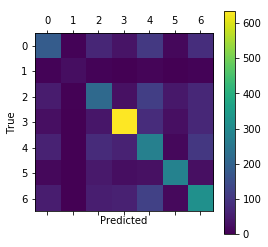

In [13]:
plot_confusion_matrix(cls_pred=preds, cls_true=labels_test_class)

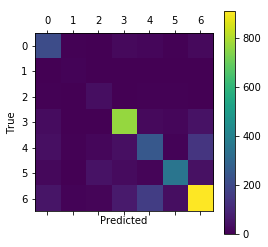

In [6]:
cm = [[213,   5,   2,  22,  16,   6,  24],
 [  0,   8,   0,   0,   0,   0,   1],
 [  4,   0,  34,   2,   5,   6,   3],
 [ 30,   2,   1, 769,  24,  16,  43],
 [ 37,   7,  17,  38, 250,   8, 139],
 [ 20,   2,  44,  25,  13, 353,  41],
 [ 53,  10,  13,  66, 164,  34, 912]]

# Plot the confusion matrix as an image.
plt.matshow(cm)

# Make various adjustments to the plot.
plt.colorbar()
tick_marks = np.arange(7)
plt.xticks(tick_marks, range(7))
plt.yticks(tick_marks, range(7))
plt.xlabel('Predicted')
plt.ylabel('True')

# Ensure the plot is shown correctly with multiple plots
# in a single Notebook cell.
plt.show()